## Clustering: kaggle Mall Customers
https://www.kaggle.com/shwetabh123/mall-customers

** Dataset Information: **

200 mall customer information

** Attribute Information: (5 features)**

- CustomerID	
- Genre	
- Age	
- Annual Income (k$)	
- Spending Score (1-100)

** Objective of this project **

Cluster customers using two features (Income and Spending score)

## Data

In [1]:
import findspark
findspark.init('/home/danny/spark-2.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('mall_customer').getOrCreate()

In [2]:
# Load Data
df = spark.read.csv('Mall_Customers.csv',inferSchema=True,header=True)
# Inspect Data
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [3]:
df.show(5)

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows



In [4]:
df.head()

Row(CustomerID=1, Genre='Male', Age=19, Annual Income (k$)=15, Spending Score (1-100)=39)

In [5]:
df.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



## Data preprocessing

In [6]:
from pyspark.ml.feature import VectorAssembler,StandardScaler

** Format Input Data **

In [7]:
df.columns

['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [8]:
# combine features into a single column
assembler = VectorAssembler(inputCols=['Annual Income (k$)',
                                       'Spending Score (1-100)'],
                            outputCol='features')
final_data = assembler.transform(df)
final_data.show(5)

+----------+------+---+------------------+----------------------+-----------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|   features|
+----------+------+---+------------------+----------------------+-----------+
|         1|  Male| 19|                15|                    39|[15.0,39.0]|
|         2|  Male| 21|                15|                    81|[15.0,81.0]|
|         3|Female| 20|                16|                     6| [16.0,6.0]|
|         4|Female| 23|                16|                    77|[16.0,77.0]|
|         5|Female| 31|                17|                    40|[17.0,40.0]|
+----------+------+---+------------------+----------------------+-----------+
only showing top 5 rows



** Scale Features **

In [9]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
final_data = scaler.fit(final_data).transform(final_data)

## K-Means Clustering

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
%matplotlib inline

** Optimal K **

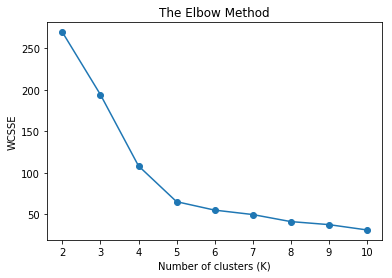

In [11]:
seed = 101
wcsse = np.zeros(len(range(2, 11)))
for i in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures',k=i, initMode='k-means||', seed=seed)
    model = kmeans.fit(final_data)
    #Within Set Sum of Squared Errors
    wcsse[i-2] = model.computeCost(final_data)
    
plt.plot(range(2, 11), wcsse, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSSE')
plt.show()

** Train & Evaluate Model  **

In [12]:
# Train model
kmeans = KMeans(featuresCol='scaledFeatures',k=5)
model = kmeans.fit(final_data)
# Evaluate model
wssse = model.computeCost(final_data)
print("Within Set Sum of Squared Errors = {:.3f}".format(wssse))

Within Set Sum of Squared Errors = 65.251


** Results **

In [13]:
# Shows the result.
cluster_centers = model.clusterCenters()
print("Cluster Centers: ")
for center in cluster_centers:
    print(center)

Cluster Centers: 
[1.00150874 0.80984475]
[0.97953725 3.07330802]
[3.3409835  0.68090377]
[3.29485552 3.18036425]
[2.0973952 1.925086 ]


In [14]:
model.transform(final_data).select(['scaledFeatures','prediction']).show(10)                 

+--------------------+----------+
|      scaledFeatures|prediction|
+--------------------+----------+
|[0.57110829030364...|         0|
|[0.57110829030364...|         1|
|[0.60918217632388...|         0|
|[0.60918217632388...|         1|
|[0.64725606234413...|         0|
|[0.64725606234413...|         1|
|[0.68532994836437...|         0|
|[0.68532994836437...|         1|
|[0.72340383438461...|         0|
|[0.72340383438461...|         1|
+--------------------+----------+
only showing top 10 rows



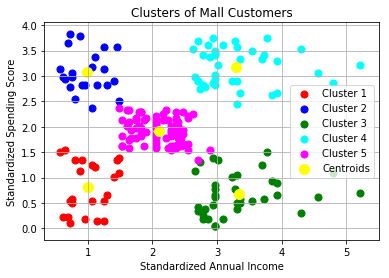

In [15]:
# Visualising the clusters
X = np.array(final_data.select('scaledFeatures').collect()).reshape(200,2)
y_kmeans = np.array(model.transform(final_data).select('prediction').collect()).ravel()
cluster_centers = np.array(cluster_centers)

plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Mall Customers')
plt.xlabel('Standardized Annual Income')
plt.ylabel('Standardized Spending Score')
plt.grid()
plt.legend()

In [16]:
spark.stop()